In [1]:
import sys
from pathlib import Path

def add_backend_to_path():
    roots = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for r in roots:
        b = r / "backend"
        if (b / "utils").exists():
            sys.path.insert(0, str(b))
            print("Using backend path:", b)
            return b
    raise RuntimeError("Could not find ./backend. Start Jupyter from repo root.")

BACKEND = add_backend_to_path()


Using backend path: /home/elahe/user/elahe/new-ai-ran-sim/backend


In [2]:
from utils.traffic_trace import (
    validate_raw_packet_trace_csv,
    validate_preaggregated_trace_csv,
    load_raw_packet_csv,
    load_csv_trace,
)
from pathlib import Path


In [4]:
# For raw CSVs (Wireshark exports)
UE_IP = "172.30.1.1"   # used to classify DL/UL
TRACE_BIN = 1.0        # seconds
OVERHEAD_BYTES = 70    # per-packet header/trailer subtraction

# Replay harness parameters
SPEEDUP = 1.0          # 1.0 = realtime
STEP_S = 1.0           # step size of the harness
CAP_Mbps = 20.0        # constant capacity used to 'serve' from buffer

# Files to test
FILES = [
    "backend/assets/traces/embb_04_10.csv",
    "backend/assets/traces/urllc_04_10.csv",
    "backend/assets/traces/mmtc_04_10.csv",
]
print(FILES)
FILES = [f for f in FILES if Path(f).exists()]
print("Files:", FILES)


['backend/assets/traces/embb_04_10.csv', 'backend/assets/traces/urllc_04_10.csv', 'backend/assets/traces/mmtc_04_10.csv']
Files: []


In [6]:
from pathlib import Path

def find_backend(start: Path = Path.cwd()) -> Path:
    p = start
    for _ in range(7):
        if p.name == 'backend' and (p/'assets'/'traces').exists():
            return p
        if (p/'backend'/'assets'/'traces').exists():
            return p/'backend'
        p = p.parent
    raise FileNotFoundError('backend/assets/traces not found upward from ' + str(start))

BACKEND = find_backend()
TRACES = BACKEND / 'assets' / 'traces'
FILES = [str(TRACES / n) for n in ('embb_04_10.csv','urllc_04_10.csv','mmtc_04_10.csv') if (TRACES / n).exists()]
print('BACKEND:', BACKEND)
print('Files:', FILES)


BACKEND: /home/elahe/user/elahe/new-ai-ran-sim/backend
Files: ['/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv']


In [8]:
# Raw packet CSVs
for f in FILES:
    res = validate_raw_packet_trace_csv(f)
    print("\nFile:", f)
    print("  exists=", res["exists"], "valid=", res["valid"])
    print("  columns=", res.get("columns"))
    print("  sample_rows_parsed=", res.get("sample_count"), "ue_ip_auto=", res.get("detected_ue_ip"))
    if not res["valid"]:
        print("  error=", res.get("error"))

# If you have pre-aggregated CSVs (t_s,dl_bytes[,ul_bytes]):
# agg_files = ["path/to/embb.csv", "path/to/urllc.csv"]
# for f in agg_files:
#     res = validate_preaggregated_trace_csv(f)
#     print("\nAgg File:", f, "->", res)



File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1

File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1

File: /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv
  exists= True valid= True
  columns= {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
  sample_rows_parsed= 100 ue_ip_auto= 172.30.1.1


In [ ]:
def load_samples_raw(path, ue_ip=UE_IP, bin_s=TRACE_BIN, overhead=OVERHEAD_BYTES):
    samples = load_raw_packet_csv(path, ue_ip=ue_ip, bin_s=bin_s, overhead_sub_bytes=overhead)
    if samples:
        total_dl = sum(int(s[1] or 0) for s in samples)
        total_ul = sum(int(s[2] or 0) for s in samples)
        duration = samples[-1][0] - samples[0][0] if len(samples) > 1 else 0.0
        print(f"samples={len(samples)}, duration={duration:.3f}s, total_dl={total_dl}B, total_ul={total_ul}B")
        print("head:", samples[:5])
        print("tail:", samples[-5:])
    else:
        print("No samples parsed.")
    return samples


# def load_samples_agg(path):
#     samples = load_csv_trace(path)
#     if samples:
#         total_dl = sum(int(s[1] or 0) for s in samples)
#         total_ul = sum(int(s[2] or 0) for s in samples)
#         duration = samples[-1][0] - samples[0][0] if len(samples) > 1 else 0.0
#         print(f"samples={len(samples)}, duration={duration:.3f}s, total_dl={total_dl}B, total_ul={total_ul}B")
#         print("head:", samples[:5])
#         print("tail:", samples[-5:])
#     else:
#         print("No samples parsed.")
#     return samples

SAMPLES = load_samples_raw(FILES[0])  # choose one file to start


samples=60, duration=294.000s, total_dl=10856852B, total_ul=365094B
head: [(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054)]
tail: [(286.0, 410, 1224), (290.0, 1018498, 51108), (291.0, 410808, 9016), (292.0, 182, 1690), (294.0, 880, 21222)]


In [10]:
class SimpleReplayer:
    def __init__(self, samples, speedup=SPEEDUP):
        self.samples = list(samples)
        self.idx = 0
        self.clock = 0.0
        self.speedup = float(speedup)
        self.buf_dl = 0
        self.buf_ul = 0
        self.enq_total = 0
        self.served_total = 0
        self.history = []

    def _tick_trace(self, dt):
        self.clock += dt * self.speedup
        step_enq = 0
        n = len(self.samples)
        while self.idx < n and self.samples[self.idx][0] <= self.clock:
            _, dl, ul = self.samples[self.idx]
            self.buf_dl += int(dl or 0)
            self.buf_ul += int(ul or 0)
            step_enq += int(dl or 0)
            self.idx += 1
        return step_enq

    def step(self, dt=STEP_S, cap_mbps=CAP_Mbps):
        enq_dl = self._tick_trace(dt)
        cap_bytes = int((cap_mbps * 1e6) * dt / 8.0)
        take = min(self.buf_dl, cap_bytes)
        self.buf_dl -= take
        self.enq_total += enq_dl
        self.served_total += take
        rec = {"t": self.clock, "enq_dl": enq_dl, "served": take, "buf_dl": self.buf_dl, "idx": self.idx}
        self.history.append(rec)
        return rec

    def run(self, steps=30, dt=STEP_S, cap_mbps=CAP_Mbps, verbose=True):
        for s in range(steps):
            rec = self.step(dt, cap_mbps)
            if verbose and s < 10:
                print(f"step={s} t={rec['t']:.2f}s enq={rec['enq_dl']}B served={rec['served']}B buf={rec['buf_dl']}B idx={rec['idx']}")
        ok = (self.enq_total == self.served_total + self.buf_dl)
        print(f"\nSummary: enq={self.enq_total}B served={self.served_total}B remaining_buf={self.buf_dl}B -> {'OK' if ok else 'MISMATCH'}")
        return ok


In [11]:
replayer = SimpleReplayer(SAMPLES, speedup=SPEEDUP)
replayer.run(steps=30, dt=STEP_S, cap_mbps=CAP_Mbps, verbose=True)


step=0 t=1.00s enq=35500B served=35500B buf=0B idx=2
step=1 t=2.00s enq=22206B served=22206B buf=0B idx=3
step=2 t=3.00s enq=1020436B served=1020436B buf=0B idx=4
step=3 t=4.00s enq=380990B served=380990B buf=0B idx=5
step=4 t=5.00s enq=187742B served=187742B buf=0B idx=6
step=5 t=6.00s enq=0B served=0B buf=0B idx=6
step=6 t=7.00s enq=0B served=0B buf=0B idx=7
step=7 t=8.00s enq=242B served=242B buf=0B idx=8
step=8 t=9.00s enq=0B served=0B buf=0B idx=8
step=9 t=10.00s enq=0B served=0B buf=0B idx=8

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK


True

In [12]:
def run_batch(files=FILES, cap_list=(10.0, 50.0)):
    for f in files:
        print("\n===", f, "===")
        samples = load_samples_raw(f)
        for cap in cap_list:
            print(f"\nCapacity {cap} Mbps")
            SimpleReplayer(samples, speedup=SPEEDUP).run(steps=30, dt=STEP_S, cap_mbps=cap, verbose=False)

run_batch()



=== /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv ===
samples=60, duration=294.000s, total_dl=10856852B, total_ul=365094B
head: [(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054)]
tail: [(286.0, 410, 1224), (290.0, 1018498, 51108), (291.0, 410808, 9016), (292.0, 182, 1690), (294.0, 880, 21222)]

Capacity 10.0 Mbps

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK

Capacity 50.0 Mbps

Summary: enq=3043830B served=3043830B remaining_buf=0B -> OK

=== /home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv ===
samples=401, duration=426.000s, total_dl=23957902B, total_ul=14647696B
head: [(0.0, 0, 58), (8.0, 14626, 8070), (9.0, 2728, 182), (10.0, 136, 170), (11.0, 106, 68)]
tail: [(421.0, 106, 136), (422.0, 186, 136), (423.0, 38, 34), (424.0, 38, 34), (426.0, 0, 34)]

Capacity 10.0 Mbps

Summary: enq=25410B served=25410B remaining_buf=0B -> OK

Capacity 50.0 Mbps

Summary: en

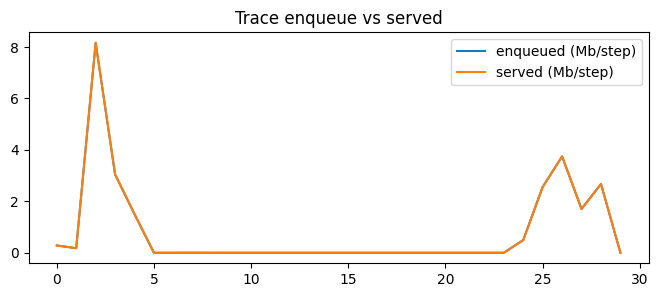

In [13]:
try:
    import matplotlib.pyplot as plt
    h = replayer.history
    enq = [r["enq_dl"] * 8 / 1e6 for r in h]
    srv = [r["served"] * 8 / 1e6 for r in h]
    plt.figure(figsize=(8,3))
    plt.plot(enq, label="enqueued (Mb/step)")
    plt.plot(srv, label="served (Mb/step)")
    plt.legend(); plt.title("Trace enqueue vs served"); plt.show()
except Exception as e:
    print("Plot skipped:", e)


### Replaying the traces more than once

In [14]:
from pathlib import Path
import sys, time

# Add backend/ to sys.path (works from repo root or backend/notebooks)
def add_backend_to_path():
    p = Path.cwd()
    for _ in range(7):
        if (p/'backend'/'utils').exists():
            sys.path.insert(0, str(p/'backend'))
            print('Using backend path:', p/'backend')
            return p/'backend'
        p = p.parent
    raise RuntimeError('backend/ not found from ' + str(Path.cwd()))

BACKEND = add_backend_to_path()

from utils.traffic_trace import load_raw_packet_csv, validate_raw_packet_trace_csv


Using backend path: /home/elahe/user/elahe/new-ai-ran-sim/backend


In [19]:
TRACES = (BACKEND / 'assets' / 'traces')
FILES = [
    str(TRACES / 'embb_04_10.csv'),
    str(TRACES / 'urllc_04_10.csv'),
    str(TRACES / 'mmtc_04_10.csv'),
]
FILES = [f for f in FILES if Path(f).exists()]
print('Files:', FILES)

UE_IP = '172.30.1.1'
TRACE_BIN = 1.0
OVERHEAD = 70

def load_samples(path, ue_ip=UE_IP, bin_s=TRACE_BIN, overhead=OVERHEAD):
    info = validate_raw_packet_trace_csv(path)
    print('Validated:', info['valid'], info.get('columns'))
    samples = load_raw_packet_csv(path, ue_ip=ue_ip, bin_s=bin_s, overhead_sub_bytes=overhead)
    print(samples)
    if samples:
        total_dl = sum(int(s[1] or 0) for s in samples)
        total_ul = sum(int(s[2] or 0) for s in samples)
        duration = samples[-1][0] - samples[0][0] if len(samples) > 1 else 0.0
        print(f'samples={len(samples)} duration={duration:.3f}s total_dl={total_dl}B total_ul={total_ul}B')
    return samples

SAMPLES = load_samples(FILES[0])


Files: ['/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv']
Validated: True {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
[(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054), (5.0, 187742, 1388), (7.0, 0, 630), (8.0, 242, 84), (24.0, 18, 0), (25.0, 61658, 5556), (26.0, 319770, 3488), (27.0, 468202, 7800), (28.0, 212730, 6460), (29.0, 334336, 1360), (33.0, 428, 1118), (50.0, 0, 5096), (51.0, 1086256, 8634), (52.0, 27056, 298), (58.0, 242, 714), (60.0, 295882, 26156), (61.0, 1284, 38), (78.0, 0, 5096), (79.0, 772198, 4814), (83.0, 9682, 8044), (84.0, 21194, 6006), (93.0, 104286, 5408), (94.0, 478978, 7688), (95.0, 287970, 2954), (109.0, 372, 1452), (114.0, 615846, 12462), (115.0, 305966, 1634), (134.0, 362, 1140), (136.0, 0, 510

In [ ]:
class RealTimeReplayer:
    """
    Replays (t, dl_bytes, ul_bytes) at wall-clock pace.
    - speedup=1.0: realtime. >1.0: faster than real time.
    - loop=True: repeat forever until KeyboardInterrupt.
    - on_emit: callback(elapsed_s, dl, ul, cycle, idx)
    """
    def __init__(self, samples, speedup=1.0, loop=False, on_emit=None):
        self.samples = list(samples)
        self.speedup = max(1e-6, float(speedup))
        self.loop = bool(loop)
        self.period = self.samples[-1][0] if self.samples else 0.0
        self.on_emit = on_emit or (lambda elapsed, dl, ul, cycle, idx: None)

    def run(self):
        if not self.samples:
            print('No samples to replay.')
            return
        t0 = time.perf_counter()
        cycle = 0
        try:
            while True:
                base = cycle * (self.period / self.speedup)  # wall-clock offset for this cycle
                for idx, (t, dl, ul) in enumerate(self.samples):
                    target = t0 + base + (t / self.speedup)
                    now = time.perf_counter()
                    sleep = target - now
                    if sleep > 0:
                        time.sleep(sleep)
                    self.on_emit(time.perf_counter() - t0, int(dl or 0), int(ul or 0), cycle, idx)
                if not self.loop:
                    break
                cycle += 1
        except KeyboardInterrupt:
            print('Stopped by user.')


In [17]:
def on_emit_print(elapsed, dl, ul, cycle, idx):
    # Print only non-zero dl to reduce noise
    if dl or ul:
        print(f'[{elapsed:7.3f}s] cycle={cycle} idx={idx} dl={dl}B ul={ul}B')

# Once (realtime)
RealTimeReplayer(SAMPLES, speedup=1.0, loop=False, on_emit=on_emit_print).run()

# Or, loop forever until you interrupt the cell (Ctrl/Cmd + C in terminal, or stop button)
# RealTimeReplayer(SAMPLES, speedup=1.0, loop=True, on_emit=on_emit_print).run()


[  0.000s] cycle=0 idx=0 dl=15048B ul=9394B
[  1.000s] cycle=0 idx=1 dl=20452B ul=22544B
[  2.000s] cycle=0 idx=2 dl=22206B ul=16332B
[  3.000s] cycle=0 idx=3 dl=1020436B ul=18598B
[  4.000s] cycle=0 idx=4 dl=380990B ul=6054B
[  5.000s] cycle=0 idx=5 dl=187742B ul=1388B
[  7.000s] cycle=0 idx=6 dl=0B ul=630B
[  8.000s] cycle=0 idx=7 dl=242B ul=84B
[ 24.000s] cycle=0 idx=8 dl=18B ul=0B
[ 25.000s] cycle=0 idx=9 dl=61658B ul=5556B
[ 26.000s] cycle=0 idx=10 dl=319770B ul=3488B
[ 27.000s] cycle=0 idx=11 dl=468202B ul=7800B
[ 28.000s] cycle=0 idx=12 dl=212730B ul=6460B
[ 29.000s] cycle=0 idx=13 dl=334336B ul=1360B
[ 33.000s] cycle=0 idx=14 dl=428B ul=1118B
[ 50.000s] cycle=0 idx=15 dl=0B ul=5096B
[ 51.000s] cycle=0 idx=16 dl=1086256B ul=8634B
[ 52.000s] cycle=0 idx=17 dl=27056B ul=298B
[ 58.000s] cycle=0 idx=18 dl=242B ul=714B
[ 60.000s] cycle=0 idx=19 dl=295882B ul=26156B
[ 61.000s] cycle=0 idx=20 dl=1284B ul=38B
[ 78.000s] cycle=0 idx=21 dl=0B ul=5096B
[ 79.000s] cycle=0 idx=22 dl=772198B 

In [18]:
class RealTimeStepServer:
    """
    1s step scheduler (realtime) with simple queue + constant serving capacity.
    Shows enqueued this step, served this step, and remaining buffer.
    """
    def __init__(self, samples, speedup=1.0, mbps=20.0, step_s=1.0, loop=False):
        self.samples = list(samples)
        self.speedup = max(1e-6, float(speedup))
        self.mbps = float(mbps)
        self.step_s = float(step_s)
        self.loop = bool(loop)
        self.buf_dl = 0
        self.idx = 0
        self.period = self.samples[-1][0] if self.samples else 0.0

    def _enqueue_until(self, clock_s):
        enq = 0
        n = len(self.samples)
        while self.idx < n and self.samples[self.idx][0] <= clock_s:
            _, dl, _ = self.samples[self.idx]
            self.buf_dl += int(dl or 0)
            enq += int(dl or 0)
            self.idx += 1
        return enq

    def run(self, seconds=30):
        if not self.samples:
            print('No samples to replay.')
            return
        t0 = time.perf_counter()
        step = 0
        cycle_add = 0.0  # offset added to the trace time when looping
        while True:
            # schedule next tick
            target = t0 + step * self.step_s
            now = time.perf_counter()
            if target > now:
                time.sleep(target - now)
            # trace clock at this step
            clock = (step * self.step_s) * self.speedup - cycle_add
            if clock >= self.period and self.loop:
                # move to next cycle
                while clock >= self.period:
                    clock -= self.period
                    cycle_add += self.period
                    self.idx = 0
            enq = self._enqueue_until(clock)
            cap_bytes = int(self.mbps * 1e6 * self.step_s / 8.0)
            served = min(self.buf_dl, cap_bytes)
            self.buf_dl -= served
            print(f"t={step:4d}s enq={enq:7d}B served={served:7d}B buf={self.buf_dl:7d}B")
            step += 1
            if not self.loop and step >= seconds:
                break

# Example: realtime step server for 30s, 20 Mbps, loop disabled
RealTimeStepServer(SAMPLES, speedup=1.0, mbps=20.0, step_s=1.0, loop=False).run(seconds=30)

# Example: loop forever until you stop it
# RealTimeStepServer(SAMPLES, speedup=1.0, mbps=20.0, step_s=1.0, loop=True).run()


t=   0s enq=  15048B served=  15048B buf=      0B
t=   1s enq=  20452B served=  20452B buf=      0B
t=   2s enq=  22206B served=  22206B buf=      0B
t=   3s enq=1020436B served=1020436B buf=      0B
t=   4s enq= 380990B served= 380990B buf=      0B
t=   5s enq= 187742B served= 187742B buf=      0B
t=   6s enq=      0B served=      0B buf=      0B
t=   7s enq=      0B served=      0B buf=      0B
t=   8s enq=    242B served=    242B buf=      0B
t=   9s enq=      0B served=      0B buf=      0B
t=  10s enq=      0B served=      0B buf=      0B
t=  11s enq=      0B served=      0B buf=      0B
t=  12s enq=      0B served=      0B buf=      0B
t=  13s enq=      0B served=      0B buf=      0B
t=  14s enq=      0B served=      0B buf=      0B
t=  15s enq=      0B served=      0B buf=      0B
t=  16s enq=      0B served=      0B buf=      0B
t=  17s enq=      0B served=      0B buf=      0B
t=  18s enq=      0B served=      0B buf=      0B
t=  19s enq=      0B served=      0B buf=      0B


### Code for real-time plot with the looping

In [20]:
# Works from repo root or backend/notebooks
from pathlib import Path
import sys, time

def add_backend_to_path():
    p = Path.cwd()
    for _ in range(7):
        if (p/'backend'/'utils').exists():
            sys.path.insert(0, str(p/'backend'))
            print('Using backend path:', p/'backend')
            return p/'backend'
        p = p.parent
    raise RuntimeError('backend/ not found from ' + str(Path.cwd()))

BACKEND = add_backend_to_path()

from utils.traffic_trace import load_raw_packet_csv, validate_raw_packet_trace_csv

TRACES = BACKEND / 'assets' / 'traces'
UE_IP = '172.30.1.1'
TRACE_BIN = 1.0
OVERHEAD = 70

FILES = [TRACES/'embb_04_10.csv', TRACES/'urllc_04_10.csv', TRACES/'mmtc_04_10.csv']
FILES = [str(f) for f in FILES if f.exists()]
print('Files:', FILES)

def load_samples(path, ue_ip=UE_IP, bin_s=TRACE_BIN, overhead=OVERHEAD):
    info = validate_raw_packet_trace_csv(path)
    print('Validated:', info['valid'], info.get('columns'))
    s = load_raw_packet_csv(path, ue_ip=ue_ip, bin_s=bin_s, overhead_sub_bytes=overhead)
    if s:
        total_dl = sum(int(x[1] or 0) for x in s)
        total_ul = sum(int(x[2] or 0) for x in s)
        duration = s[-1][0] - s[0][0] if len(s) > 1 else 0.0
        print(f'samples={len(s)} duration={duration:.3f}s total_dl={total_dl}B total_ul={total_ul}B')
    return s

SAMPLES = load_samples(FILES[0])


Using backend path: /home/elahe/user/elahe/new-ai-ran-sim/backend
Files: ['/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/embb_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/urllc_04_10.csv', '/home/elahe/user/elahe/new-ai-ran-sim/backend/assets/traces/mmtc_04_10.csv']
Validated: True {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'}
samples=60 duration=294.000s total_dl=10856852B total_ul=365094B


In [21]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

class LiveStepLooper:
    """
    Real-time step scheduler that:
      - loops the trace (optional),
      - enqueues per step according to trace clock (speedup applied),
      - serves from a buffer with constant capacity,
      - updates a live plot (Mb/s) for enqueued vs served.
    """
    def __init__(self, samples, mbps=20.0, step_s=1.0, speedup=1.0, loop=True):
        assert samples, "No samples"
        self.samples = list(samples)
        self.period = float(self.samples[-1][0]) if len(self.samples) else 0.0
        self.mbps = float(mbps)
        self.step_s = float(step_s)
        self.speedup = max(1e-6, float(speedup))
        self.loop = bool(loop)
        self.reset()

    def reset(self):
        self.idx = 0
        self.buf_dl = 0
        self.enq_total = 0
        self.served_total = 0
        self._last_clock = 0.0

    def _enqueue_until_clock(self, clock_s):
        enq = 0
        n = len(self.samples)
        # Detect wrap (only when looping)
        if self.loop and self.period > 0 and clock_s < self._last_clock:
            self.idx = 0  # new cycle
        while self.idx < n and self.samples[self.idx][0] <= clock_s:
            _, dl, _ = self.samples[self.idx]
            dl = int(dl or 0)
            self.buf_dl += dl
            enq += dl
            self.idx += 1
        self._last_clock = clock_s
        return enq

    def run(self, duration_s=30, print_first_n=10, slide_window_s=30):
        # Live plot init
        plt.ion()
        fig, ax = plt.subplots(figsize=(8,3))
        ax.set_title("Trace replay (realtime)")
        ax.set_xlabel("time (s)")
        ax.set_ylabel("Mb/s")
        line_enq, = ax.plot([], [], label="enqueued")
        line_srv, = ax.plot([], [], label="served")
        ax.legend(loc="upper right")

        t0 = time.perf_counter()
        times, enq_mbps, srv_mbps = [], [], []
        step = 0
        try:
            while True:
                target = t0 + step * self.step_s
                now = time.perf_counter()
                if target > now:
                    time.sleep(target - now)
                elapsed = time.perf_counter() - t0

                # Logical trace clock (loops when enabled)
                clock = (elapsed * self.speedup)
                if self.loop and self.period > 0:
                    clock = clock % self.period

                enq = self._enqueue_until_clock(clock)
                cap_bytes = int(self.mbps * 1e6 * self.step_s / 8.0)
                served = min(self.buf_dl, cap_bytes)
                self.buf_dl -= served
                self.enq_total += enq
                self.served_total += served

                # Print first few lines for sanity
                if step < print_first_n:
                    print(f"t={elapsed:6.2f}s enq={enq:7d}B served={served:7d}B buf={self.buf_dl:7d}B idx={self.idx}")

                # Update live plot
                times.append(elapsed)
                enq_mbps.append(enq * 8 / 1e6 / self.step_s)
                srv_mbps.append(served * 8 / 1e6 / self.step_s)
                line_enq.set_data(times, enq_mbps)
                line_srv.set_data(times, srv_mbps)
                # Sliding window
                xmin = max(0.0, elapsed - slide_window_s)
                xmax = elapsed + self.step_s
                ax.set_xlim(xmin, xmax)
                ymax = max(1.0, max(enq_mbps[-slide_window_s:], default=0.0), max(srv_mbps[-slide_window_s:], default=0.0)) * 1.2
                ax.set_ylim(0, ymax)
                clear_output(wait=True)
                display(fig)

                step += 1
                if not self.loop and elapsed >= duration_s:
                    break
                if self.loop and elapsed >= duration_s:
                    # For looping demo, stop after duration unless you want continuous run
                    break
            ok = (self.enq_total == self.served_total + self.buf_dl)
            print(f"\nSummary: enq={self.enq_total}B served={self.served_total}B remaining_buf={self.buf_dl}B -> {'OK' if ok else 'MISMATCH'}")
        finally:
            plt.ioff()
            plt.show()


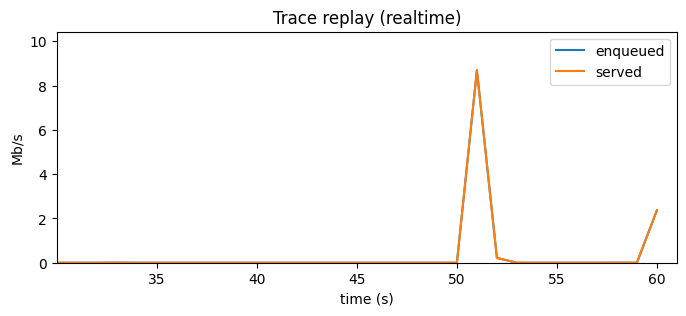


Summary: enq=4453694B served=4453694B remaining_buf=0B -> OK


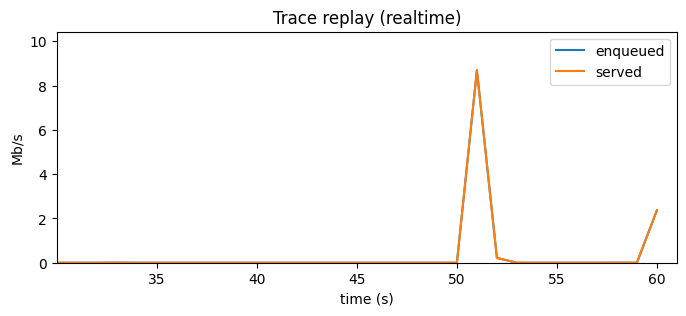

In [23]:
# One-shot (no loop), 30 seconds
#LiveStepLooper(SAMPLES, mbps=20.0, step_s=1.0, speedup=1.0, loop=False).run(duration_s=30)

# Looping for 60 seconds (stops after 60s; set a larger duration to keep going)
LiveStepLooper(SAMPLES, mbps=20.0, step_s=1.0, speedup=1.0, loop=True).run(duration_s=60)


### force Queing

In [26]:
def trace_stats(samples):
    if not samples: return {}
    total_dl = sum(int(s[1] or 0) for s in samples)
    dur = (samples[-1][0] - samples[0][0]) or 1.0
    avg_mbps = total_dl * 8 / 1e6 / dur
    # crude peak (assumes ~uniform binning)
    per_bin = []
    for i,(t,dl,_) in enumerate(samples):
        dt = (samples[i+1][0]-t) if i+1 < len(samples) else (samples[1][0]-samples[0][0] if len(samples)>1 else 1.0)
        per_bin.append((dl*8/1e6)/max(1e-9,dt))
    return {"avg_mbps": avg_mbps, "peak_mbps": max(per_bin) if per_bin else avg_mbps}

st = trace_stats(SAMPLES)
print("avg_mbps=", st["avg_mbps"], "peak_mbps=", st["peak_mbps"])


avg_mbps= 0.29542454421768705 peak_mbps= 8.690048


In [27]:
class RealTimeStepServer:
    """
    1s step scheduler (realtime) with queue + constant serving capacity.
    Keeps per-step history for assertions/plots.
    """
    def __init__(self, samples, speedup=1.0, mbps=20.0, step_s=1.0, loop=False):
        self.samples = list(samples)
        self.speedup = max(1e-6, float(speedup))
        self.mbps = float(mbps)
        self.step_s = float(step_s)
        self.loop = bool(loop)
        self.buf_dl = 0
        self.idx = 0
        self.period = self.samples[-1][0] if self.samples else 0.0
        self.history = []           # <-- added
        self.enq_total = 0          # optional counters
        self.served_total = 0

    def _enqueue_until(self, clock_s):
        enq = 0
        n = len(self.samples)
        while self.idx < n and self.samples[self.idx][0] <= clock_s:
            _, dl, _ = self.samples[self.idx]
            d = int(dl or 0)
            self.buf_dl += d
            enq += d
            self.idx += 1
        return enq

    def run(self, seconds=30):
        if not self.samples:
            print('No samples to replay.')
            return []
        import time
        t0 = time.perf_counter()
        step = 0
        while True:
            target = t0 + step * self.step_s
            now = time.perf_counter()
            if target > now:
                time.sleep(target - now)
            elapsed = time.perf_counter() - t0

            # logical trace clock (no looping here; add if you need)
            clock = elapsed * self.speedup
            enq = self._enqueue_until(clock)
            cap_bytes = int(self.mbps * 1e6 * self.step_s / 8.0)
            served = min(self.buf_dl, cap_bytes)
            self.buf_dl -= served
            self.enq_total += enq
            self.served_total += served

            rec = {"t": elapsed, "enq_dl": enq, "served": served, "buf_dl": self.buf_dl, "idx": self.idx}
            self.history.append(rec)          # <-- added

            step += 1
            if step >= seconds:
                break
        return self.history                  # <-- added


In [29]:
cap = 0.5 * st["avg_mbps"]  # 50% of average -> sustained queue
srv = RealTimeStepServer(SAMPLES, speedup=1.0, mbps=cap, step_s=1.0, loop=False)
srv.run(seconds=30)
# Assert queue formed at least once and accounting is consistent
assert any(h["buf_dl"] > 0 for h in srv.history), "No queue formed"
assert srv.served_total + srv.buf_dl == srv.enq_total, "Accounting mismatch"


### the last work with plot addition

In [30]:
# Adjust to your CWD (works from repo root or backend/notebooks)
from pathlib import Path
import sys

def add_backend_to_path():
    p = Path.cwd()
    for _ in range(7):
        if (p/'backend'/'utils').exists():
            sys.path.insert(0, str(p/'backend'))
            print('Using backend path:', p/'backend')
            return p/'backend'
        p = p.parent
    raise RuntimeError('backend/ not found from ' + str(Path.cwd()))

BACKEND = add_backend_to_path()

from utils.traffic_trace import load_raw_packet_csv, validate_raw_packet_trace_csv

TRACES = BACKEND / 'assets' / 'traces'
FILE = TRACES / 'embb_04_10.csv'   # pick one
UE_IP = '172.30.1.1'               # or None to auto-detect
TRACE_BIN = 1.0
OVERHEAD = 70

print('CWD:', Path.cwd())
print('FILE exists?', FILE.exists())

info = validate_raw_packet_trace_csv(str(FILE))
print('Validated:', info['valid'], info.get('columns'), 'rows parsed sample:', info.get('sample_count'))

SAMPLES = load_raw_packet_csv(str(FILE), ue_ip=UE_IP, bin_s=TRACE_BIN, overhead_sub_bytes=OVERHEAD)
print('Loaded samples:', len(SAMPLES))
print('Head:', SAMPLES[:5])
assert SAMPLES, "No samples; check file path or UE_IP detection."


Using backend path: /home/elahe/user/elahe/new-ai-ran-sim/backend
CWD: /home/elahe/user/elahe/new-ai-ran-sim/backend/notebooks
FILE exists? True
Validated: True {'time': 'time', 'src': 'source', 'dst': 'destination', 'len': 'length'} rows parsed sample: 100
Loaded samples: 60
Head: [(0.0, 15048, 9394), (1.0, 20452, 22544), (2.0, 22206, 16332), (3.0, 1020436, 18598), (4.0, 380990, 6054)]


In [31]:
import time

class RealTimeStepServer:
    """
    Realtime 1s step loop:
      - enqueues by trace time (speedup applied)
      - serves from a buffer at constant capacity
      - prints each step and keeps history
    """
    def __init__(self, samples, speedup=1.0, mbps=10.0, step_s=1.0, loop=False):
        self.samples = list(samples)
        self.speedup = max(1e-6, float(speedup))
        self.mbps = float(mbps)
        self.step_s = float(step_s)
        self.loop = bool(loop)
        self.idx = 0
        self.buf_dl = 0
        self.enq_total = 0
        self.served_total = 0
        self.history = []
        self.period = self.samples[-1][0] if self.samples else 0.0
        self._last_clock = 0.0

    def _enqueue_until(self, clock_s):
        # loop if enabled and clock wrapped
        if self.loop and self.period > 0 and clock_s < self._last_clock:
            self.idx = 0
        enq = 0
        n = len(self.samples)
        while self.idx < n and self.samples[self.idx][0] <= clock_s:
            _, dl, _ = self.samples[self.idx]
            d = int(dl or 0)
            self.buf_dl += d
            enq += d
            self.idx += 1
        self._last_clock = clock_s
        return enq

    def run(self, seconds=15, print_every=1):
        if not self.samples:
            print('No samples to replay.')
            return self.history
        t0 = time.perf_counter()
        step = 0
        while True:
            # realtime pacing
            target = t0 + step * self.step_s
            now = time.perf_counter()
            if target > now:
                time.sleep(target - now)
            elapsed = time.perf_counter() - t0

            # logical trace clock (looping supported)
            clock = elapsed * self.speedup
            if self.loop and self.period > 0:
                clock = clock % self.period

            enq = self._enqueue_until(clock)
            cap_bytes = int(self.mbps * 1e6 * self.step_s / 8.0)
            served = min(self.buf_dl, cap_bytes)
            self.buf_dl -= served
            self.enq_total += enq
            self.served_total += served

            rec = {"t": elapsed, "enq_dl": enq, "served": served, "buf_dl": self.buf_dl, "idx": self.idx}
            self.history.append(rec)

            if step % max(1, int(print_every)) == 0:
                print(f"t={elapsed:6.2f}s enq={enq:7d}B served={served:7d}B buf={self.buf_dl:7d}B idx={self.idx}")

            step += 1
            if not self.loop and step >= seconds:
                break
            if self.loop and step >= seconds:
                # Stop after duration even if looping; remove this to run forever
                break

        ok = (self.enq_total == self.served_total + self.buf_dl)
        print(f"\nSummary: enq={self.enq_total}B served={self.served_total}B remaining_buf={self.buf_dl}B -> {'OK' if ok else 'MISMATCH'}")
        return self.history


In [32]:
srv = RealTimeStepServer(SAMPLES, speedup=1.0, mbps=5.0, step_s=1.0, loop=False)
hist = srv.run(seconds=15, print_every=1)


t=  0.00s enq=  15048B served=  15048B buf=      0B idx=1
t=  1.00s enq=  20452B served=  20452B buf=      0B idx=2
t=  2.00s enq=  22206B served=  22206B buf=      0B idx=3
t=  3.00s enq=1020436B served= 625000B buf= 395436B idx=4
t=  4.00s enq= 380990B served= 625000B buf= 151426B idx=5
t=  5.00s enq= 187742B served= 339168B buf=      0B idx=6
t=  6.00s enq=      0B served=      0B buf=      0B idx=6
t=  7.00s enq=      0B served=      0B buf=      0B idx=7
t=  8.00s enq=    242B served=    242B buf=      0B idx=8
t=  9.00s enq=      0B served=      0B buf=      0B idx=8
t= 10.00s enq=      0B served=      0B buf=      0B idx=8
t= 11.00s enq=      0B served=      0B buf=      0B idx=8
t= 12.00s enq=      0B served=      0B buf=      0B idx=8
t= 13.00s enq=      0B served=      0B buf=      0B idx=8
t= 14.00s enq=      0B served=      0B buf=      0B idx=8

Summary: enq=1647116B served=1647116B remaining_buf=0B -> OK


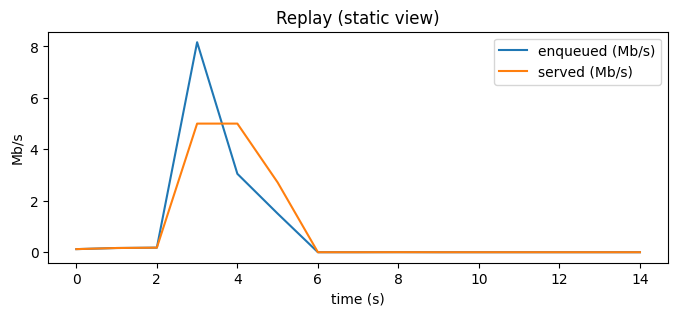

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

t = [h["t"] for h in hist]
enq = [h["enq_dl"]*8/1e6 for h in hist]
srv = [h["served"]*8/1e6 for h in hist]
plt.figure(figsize=(8,3))
plt.plot(t, enq, label="enqueued (Mb/s)")
plt.plot(t, srv, label="served (Mb/s)")
plt.legend(); plt.xlabel("time (s)"); plt.ylabel("Mb/s"); plt.title("Replay (static view)"); plt.show()


AttributeError: 'list' object has no attribute 'history'

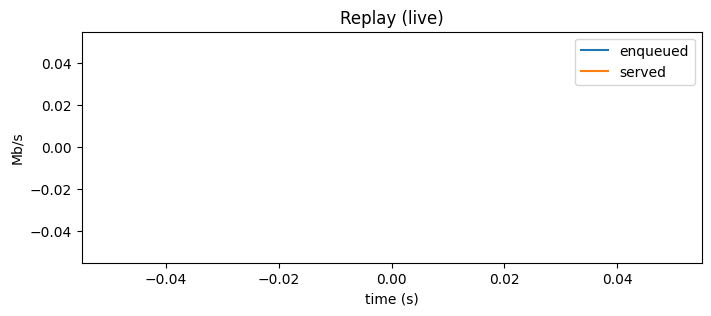

In [34]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

def live_plot(hist_window=30):
    plt.ion()
    fig, ax = plt.subplots(figsize=(8,3))
    line_enq, = ax.plot([], [], label="enqueued")
    line_srv, = ax.plot([], [], label="served")
    ax.legend(); ax.set_xlabel("time (s)"); ax.set_ylabel("Mb/s"); ax.set_title("Replay (live)")

    times, enq_mbps, srv_mbps = [], [], []
    for h in srv.history:
        times.append(h["t"])
        enq_mbps.append(h["enq_dl"]*8/1e6)
        srv_mbps.append(h["served"]*8/1e6)
        line_enq.set_data(times, enq_mbps)
        line_srv.set_data(times, srv_mbps)
        xmin = max(0.0, times[-1] - hist_window)
        ax.set_xlim(xmin, times[-1] + 1)
        ax.set_ylim(0, max(1.0, max(enq_mbps[-hist_window:], default=0), max(srv_mbps[-hist_window:], default=0))*1.2)
        clear_output(wait=True)
        display(fig)
    plt.ioff(); plt.show()

# After running the server above:
live_plot(hist_window=30)


### Test to use mixed.csv file and chunk it into data for all 3 slices

In [1]:
import os

print("Current directory:", os.getcwd())


Current directory: /home/elahe/user/elahe/new-ai-ran-sim/backend/notebooks


In [2]:
import pandas as pd

# Load your CSV
df = pd.read_csv("../assets/traces/mixed.csv")

# Get unique app names
apps = df["App name"].dropna().unique().tolist()

# Print them
print("App names in the file:")
for app in apps:
    print("-", app)


App names in the file:
- WhatsApp
- Google Play service
- Google Fi
- Messages
- Google News
- Gmail
- USAA SafePilot
- Google Connectivity
- Accountable2You
- YouTube
- Google Play Store
- Drive
- Packers
- Phone
- Meet


In [4]:
from pathlib import Path

# Define slices
embb_apps = ["YouTube"]
urllc_apps = ["Meet"]

# Filter
df_embb = df[df["App name"].isin(embb_apps)]
df_urllc = df[df["App name"].isin(urllc_apps)]
df_mmtc = df[~df["App name"].isin(embb_apps + urllc_apps)]

# Define output folder (change this to where you want)
output_dir = Path("../assets/traces/")  # example for Linux/Mac
# output_dir = Path("C:/Users/Elahe/Documents/output_csvs")  # example for Windows

# Make sure folder exists
output_dir.mkdir(parents=True, exist_ok=True)

# Save files inside that folder
df_embb.to_csv(output_dir / "eMBB.csv", index=False)
df_urllc.to_csv(output_dir / "URLLC.csv", index=False)
df_mmtc.to_csv(output_dir / "mMTC.csv", index=False)

print(f"Files saved in: {output_dir}")


Files saved in: ../assets/traces


## Add the times with zero length to have files of the same size and time duration

In [ ]:
import pandas as pd

# Load the three CSV files
df_embb = pd.read_csv("../assets/traces/eMBB.csv")
df_urllc = pd.read_csv("../assets/traces/URLLC.csv")
df_mmtc = pd.read_csv("../assets/traces/mMTC.csv")

# Build timeline from the union of all unique times
all_times = pd.concat([df_embb["Time"], df_urllc["Time"], df_mmtc["Time"]]).drop_duplicates()
timeline = pd.DataFrame({"Time": all_times.sort_values().reset_index(drop=True)})

def align_and_fill(df, timeline):
    # Merge with full timeline
    merged = pd.merge(timeline, df, on="Time", how="left")
    # Fill missing rows with 0 for Length
    if "Length" in merged.columns:
        merged["Length"] = merged["Length"].fillna(0).astype(int)
    # Fill other columns forward/backward (so App name, IPs, etc. are valid)
    for col in merged.columns:
        if col not in ["Time", "Length"]:
            merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
    return merged

# Align and fill each dataframe
df_embb_filled = align_and_fill(df_embb, timeline)
df_urllc_filled = align_and_fill(df_urllc, timeline)
df_mmtc_filled = align_and_fill(df_mmtc, timeline)

# Save the updated files
df_embb_filled.to_csv("eMBB_aligned.csv", index=False)
df_urllc_filled.to_csv("URLLC_aligned.csv", index=False)
df_mmtc_filled.to_csv("mMTC_aligned.csv", index=False)


/tmp/ipykernel_361265/767676791.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_361265/767676791.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_361265/767676791.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")


In [2]:
import pandas as pd

# Load original mixed file
df_mixed = pd.read_csv("../assets/traces/mixed.csv")

# Load the separated slice files
df_embb = pd.read_csv("../assets/traces/eMBB.csv")
df_urllc = pd.read_csv("../assets/traces/URLLC.csv")
df_mmtc = pd.read_csv("../assets/traces/mMTC.csv")

# Use mixed.csv timeline (keep duplicates)
timeline = df_mixed[["Time"]].copy().reset_index(drop=True)

def align_and_fill(df, timeline):
    merged = pd.merge(timeline, df, on="Time", how="left")
    # If packet missing, set Length=0
    if "Length" in merged.columns:
        merged["Length"] = merged["Length"].fillna(0).astype(int)
    # Fill other metadata columns forward/backward if needed
    for col in merged.columns:
        if col not in ["Time", "Length"]:
            merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
    return merged

# Align each slice
df_embb_aligned = align_and_fill(df_embb, timeline)
df_urllc_aligned = align_and_fill(df_urllc, timeline)
df_mmtc_aligned = align_and_fill(df_mmtc, timeline)

# Save results
df_embb_aligned.to_csv("../assets/traces/eMBB_aligned.csv", index=False)
df_urllc_aligned.to_csv("../assets/traces/URLLC_aligned.csv", index=False)
df_mmtc_aligned.to_csv("../assets/traces/mMTC_aligned.csv", index=False)


/tmp/ipykernel_369517/3617538536.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_369517/3617538536.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_369517/3617538536.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method="ffill").fillna(method="bfill")


## Generating fake data to validate the code

In [6]:
import csv
import random
import os

def generate_trace_with_ips(
    filename,
    duration_s=100,
    interval_s=0.1,
    length_range=(100, 500),
    seed=42,
    ue_ip="172.30.1.1",
    server_ip="172.30.1.250"
):
    random.seed(seed)
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Time', 'Source', 'Destination', 'Length'])

        time = 0.0
        while time <= duration_s:
            # Randomly decide uplink or downlink
            if random.random() < 0.5:
                srcIP, dstIP = ue_ip, server_ip  # Uplink
            else:
                srcIP, dstIP = server_ip, ue_ip  # Downlink

            length = random.randint(*length_range)
            writer.writerow([round(time, 2), srcIP, dstIP, length])
            time += interval_s

# Output directory
output_dir = 'generated_traces'
os.makedirs(output_dir, exist_ok=True)

# Settings for each slice
slice_configs = {
    'embb_gen.csv': (300, 500),
    'urllc_gen.csv': (100, 200),
    'mmtc_gen.csv': (0, 100),
}

# Generate the files
for filename, length_range in slice_configs.items():
    full_path = os.path.join(output_dir, filename)
    generate_trace_with_ips(full_path, length_range=length_range)
    print(f"✅ Generated: {full_path}")


✅ Generated: generated_traces/embb_gen.csv
✅ Generated: generated_traces/urllc_gen.csv
✅ Generated: generated_traces/mmtc_gen.csv


In [ ]:
import csv
import random

def generate_trace(
    filename,
    app_name="TestApp",
    ue_ip="172.30.1.1",
    dest_ip="172.30.1.250",
    slice_type="eMBB",
    duration=60,  # seconds
    packet_rate=10,  # packets per second
    min_size=100,  # bytes
    max_size=1500,  # bytes
    protocols=None
):
    if protocols is None:
        # Typical protocols per slice
        if slice_type == "eMBB":
            protocols = ["TCP", "QUIC", "TLSv1.3"]
        elif slice_type == "URLLC":
            protocols = ["QUIC", "TCP"]
        elif slice_type == "mMTC":
            protocols = ["UDP", "MQTT"]
        else:
            protocols = ["TCP"]

    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])
        packet_no = 1
        time = 0.0
        while time < duration:
            # For eMBB: bursty, large packets; for URLLC: frequent, small packets; for mMTC: sparse, tiny packets
            if slice_type == "eMBB":
                pkt_size = random.randint(1000, max_size)
                interval = random.expovariate(packet_rate / 2)  # bursty
            elif slice_type == "URLLC":
                pkt_size = random.randint(min_size, 300)
                interval = random.expovariate(packet_rate * 2)  # frequent, low jitter
            elif slice_type == "mMTC":
                pkt_size = random.randint(min_size, 200)
                interval = random.expovariate(packet_rate / 10)  # sparse
            else:
                pkt_size = random.randint(min_size, max_size)
                interval = random.expovariate(packet_rate)

            protocol = random.choice(protocols)
            writer.writerow([app_name, packet_no, round(time, 6), ue_ip, dest_ip, protocol, pkt_size])
            time += interval
            packet_no += 1


In [19]:
import csv
import random

def generate_trace(
    filename,
    app_name="TestApp",
    ue_ip="172.30.1.1",
    dest_ip="172.30.1.250",
    slice_type="eMBB",
    duration=60,  # seconds
    packet_rate=10,  # packets per second
    min_size=100,  # bytes
    max_size=1500,  # bytes
    protocols=None
):
    if protocols is None:
        if slice_type == "eMBB":
            protocols = ["TCP", "QUIC", "TLSv1.3"]
        elif slice_type == "URLLC":
            protocols = ["QUIC", "TCP"]
        elif slice_type == "mMTC":
            protocols = ["UDP", "MQTT"]
        else:
            protocols = ["TCP"]

    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])
        packet_no = 1
        time = 0.0
        while time < duration:
            if slice_type == "eMBB":
                pkt_size = random.randint(1000, max_size)
                interval = random.expovariate(packet_rate / 2)
            elif slice_type == "URLLC":
                pkt_size = random.randint(min_size, 300)
                interval = random.expovariate(packet_rate * 2)
            elif slice_type == "mMTC":
                pkt_size = random.randint(min_size, 200)
                interval = random.expovariate(packet_rate / 10)
            else:
                pkt_size = random.randint(min_size, max_size)
                interval = random.expovariate(packet_rate)

            protocol = random.choice(protocols)
            # Bias toward downlink for testing
            if random.random() < 0.8:
                src, dst = dest_ip, ue_ip  # Downlink
            else:
                src, dst = ue_ip, dest_ip  # Uplink
            writer.writerow([app_name, packet_no, round(time, 6), src, dst, protocol, pkt_size])
            time += interval
            packet_no += 1

In [20]:
generate_trace(
    "synthetic_embb.csv",
    slice_type="eMBB",
    duration=90,
    packet_rate=10,
    min_size=1000,
    max_size=1500
)
generate_trace(
    "synthetic_urllc.csv",
    slice_type="URLLC",
    duration=90,
    packet_rate=50,
    min_size=60,
    max_size=300
)
generate_trace(
    "synthetic_mmtc.csv",
    slice_type="mMTC",
    duration=90,
    packet_rate=1,
    min_size=20,
    max_size=200
)

In [16]:
import os

print("Current directory:", os.getcwd())
# add the parent directory (backend) to import path
sys.path.append(str(Path.cwd().parent))

Current directory: /home/elahe/user/elahe/new-ai-ran-sim/backend/notebooks


In [18]:
from utils.traffic_trace import load_raw_packet_csv, validate_raw_packet_trace_csv
samples = load_raw_packet_csv("synthetic_embb.csv", ue_ip="172.30.1.1", bin_s=1.0)
print(samples[:10])  # Should show nonzero DL bytes

[(0.0, 0, 2535), (1.0, 0, 9074), (2.0, 0, 4040), (3.0, 0, 1255), (4.0, 0, 11370), (5.0, 0, 8985), (6.0, 0, 4907), (7.0, 0, 5399), (8.0, 0, 3940), (9.0, 0, 6461)]


In [21]:
import csv
import random

def generate_queueing_trace(
    filename,
    app_name="TestApp",
    ue_ip="172.30.1.1",
    dest_ip="172.30.1.250",
    slice_type="eMBB",
    duration=60,  # seconds
    avg_rate_mbps=10,  # average traffic rate in Mbps
    serving_capacity_mbps=5,  # serving capacity in simulation (for reference)
    min_size=1000,
    max_size=1500,
    protocols=None
):
    if protocols is None:
        if slice_type == "eMBB":
            protocols = ["TCP", "QUIC", "TLSv1.3"]
        elif slice_type == "URLLC":
            protocols = ["QUIC", "TCP"]
        elif slice_type == "mMTC":
            protocols = ["UDP", "MQTT"]
        else:
            protocols = ["TCP"]

    # Calculate number of packets to exceed serving capacity
    total_bytes = avg_rate_mbps * 1e6 * duration / 8
    avg_pkt_size = (min_size + max_size) // 2
    num_packets = int(total_bytes // avg_pkt_size)

    interval = duration / num_packets
    time = 0.0

    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])
        for packet_no in range(1, num_packets + 1):
            pkt_size = random.randint(min_size, max_size)
            protocol = random.choice(protocols)
            # Force downlink for buffer buildup
            src, dst = dest_ip, ue_ip
            writer.writerow([app_name, packet_no, round(time, 6), src, dst, protocol, pkt_size])
            time += interval

# Example usage: generates 10 Mbps downlink traffic for 60s, which will overflow a 5 Mbps buffer
generate_queueing_trace("synthetic_queueing.csv", slice_type="eMBB", duration=60, avg_rate_mbps=10, serving_capacity_mbps=5)

In [24]:
import csv
import random

def generate_trace(filename, num_packets, slice_type, serving_capacity_mbps, duration_s=10):
    # Define slice characteristics
    if slice_type == "eMBB":
        packet_size = random.randint(1000, 20000)  # bytes
        direction = "DL"
        interval = duration_s / num_packets
    elif slice_type == "URLLC":
        packet_size = random.randint(50, 200)      # bytes
        direction = random.choice(["DL", "UL"])
        interval = 0.001  # very frequent
    elif slice_type == "mMTC":
        packet_size = random.randint(20, 100)      # bytes
        direction = "UL"
        interval = random.expovariate(1.0 / (duration_s / num_packets))
    else:
        raise ValueError("Unknown slice type")

    # Calculate traffic rate (Mbps)
    total_bytes = num_packets * packet_size
    traffic_rate_mbps = (total_bytes * 8) / (duration_s * 1e6)
    print(f"{slice_type} traffic rate: {traffic_rate_mbps:.2f} Mbps (serving capacity: {serving_capacity_mbps} Mbps)")

    # Generate packets
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "direction", "size_bytes"])
        timestamp = 0.0
        for _ in range(num_packets):
            writer.writerow([round(timestamp, 3), direction, packet_size])
            timestamp += interval

# Example usage:
generate_trace("synthetic_embb_queueing.csv", 100, "eMBB", serving_capacity_mbps=5)
generate_trace("synthetic_urllc_queueing.csv", 1000, "URLLC", serving_capacity_mbps=1)
generate_trace("synthetic_mmtc_queueing.csv", 500, "mMTC", serving_capacity_mbps=0.5)

eMBB traffic rate: 0.84 Mbps (serving capacity: 5 Mbps)
URLLC traffic rate: 0.07 Mbps (serving capacity: 1 Mbps)
mMTC traffic rate: 0.03 Mbps (serving capacity: 0.5 Mbps)


In [25]:
import csv
import random

def generate_slice_trace(filename, slice_type, num_packets, serving_capacity_mbps, duration_s=10):
    # Slice characteristics
    if slice_type == "eMBB":
        app_name = "YouTube"
        protocol = "QUIC"
        packet_size_range = (1200, 15000)
        src, dst = "172.30.1.1", "172.30.1.250"
    elif slice_type == "URLLC":
        app_name = "Meet"
        protocol = "TCP"
        packet_size_range = (60, 300)
        src, dst = "172.30.1.1", "172.30.1.250"
    elif slice_type == "mMTC":
        app_name = "IoT"
        protocol = "UDP"
        packet_size_range = (20, 100)
        src, dst = "172.30.1.1", "172.30.1.250"
    else:
        raise ValueError("Unknown slice type")

    interval = duration_s / num_packets
    timestamp = 0.0

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])
        for i in range(1, num_packets + 1):
            size = random.randint(*packet_size_range)
            writer.writerow([
                app_name,
                i,
                round(timestamp, 6),
                src,
                dst,
                protocol,
                size
            ])
            timestamp += interval

# Example usage with estimated serving capacities:
generate_slice_trace("synthetic_embb_queueing.csv", "eMBB", 100, serving_capacity_mbps=5)
generate_slice_trace("synthetic_urllc_queueing.csv", "URLLC", 500, serving_capacity_mbps=1)
generate_slice_trace("synthetic_mmtc_queueing.csv", "mMTC", 1000, serving_capacity_mbps=0.5)

In [ ]:
import csv
import random

def generate_slice_trace(filename, slice_type, num_packets, duration_s=10):
    # Slice characteristics
    if slice_type == "eMBB":
        app_name = "YouTube"
        protocol = "QUIC"
        packet_size_range = (1200, 15000)
    elif slice_type == "URLLC":
        app_name = "Meet"
        protocol = "TCP"
        packet_size_range = (60, 300)
    elif slice_type == "mMTC":
        app_name = "IoT"
        protocol = "UDP"
        packet_size_range = (20, 100)
    else:
        raise ValueError("Unknown slice type")

    interval = duration_s / num_packets
    timestamp = 0.0

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])
        for i in range(1, num_packets + 1):
            size = random.randint(*packet_size_range)
            # 80% DL, 20% UL
            if random.random() < 0.8:
                src, dst = "172.30.1.1", "172.30.1.250"  # Downlink
            else:
                src, dst = "172.30.1.250", "172.30.1.1"  # Uplink
            writer.writerow([
                app_name,
                i,
                round(timestamp, 6),
                src,
                dst,
                protocol,
                size
            ])
            timestamp += interval

# Example usage:
generate_slice_trace("synthetic_embb_queueing.csv", "eMBB", 100, duration_s=10)
generate_slice_trace("synthetic_urllc_queueing.csv", "URLLC", 500, duration_s=10)
generate_slice_trace("synthetic_mmtc_queueing.csv", "mMTC", 1000, duration_s=10)

## Generating data with overload

In [26]:
import csv
import random

def generate_overloaded_slice_trace(filename, slice_type, duration_s=10, overload_factor=2.0):
    """
    Generate synthetic traffic trace for a 5G slice that exceeds its capacity to induce queuing.
    
    Parameters:
    - filename: name of the output CSV file
    - slice_type: "eMBB", "URLLC", or "mMTC"
    - duration_s: duration of the trace in seconds
    - overload_factor: how much more traffic to generate beyond max slice capacity
    """

    # Step 1: Define slice-specific app properties and traffic behavior
    if slice_type == "eMBB":
        app_name = "YouTube"          # App label
        protocol = "QUIC"             # Transport protocol (eMBB uses QUIC)
        packet_size_range = (1200, 15000)  # Packet size range in bytes (typical video traffic)
    elif slice_type == "URLLC":
        app_name = "Meet"
        protocol = "TCP"              # Time-sensitive, reliable communication
        packet_size_range = (60, 300)  # Small, frequent packets
    elif slice_type == "mMTC":
        app_name = "IoT"
        protocol = "UDP"              # Connectionless, low-power IoT-style traffic
        packet_size_range = (20, 100)  # Very small packets
    else:
        raise ValueError("Unknown slice type")  # Safety check

    # Step 2: Set number of PRBs for all slices (fixed as 10)
    prbs = 10  # Uniform PRB allocation to each slice for this simulation

    # Step 3: Compute max throughput the slice can handle (in Mbps)
    max_throughput_mbps = prbs * 1.24475  # 1.24475 Mbps per PRB at best MCS

    # Step 4: Multiply by overload factor to decide how much traffic to generate
    target_rate_mbps = overload_factor * max_throughput_mbps

    # Step 5: Total number of bits to generate = rate × time
    total_bits = target_rate_mbps * 1e6 * duration_s

    # Step 6: Estimate average packet size to compute number of packets
    avg_packet_size_bytes = sum(packet_size_range) / 2
    avg_packet_size_bits = avg_packet_size_bytes * 8

    # Step 7: Compute how many packets are needed to generate the traffic
    num_packets = int(total_bits / avg_packet_size_bits)

    # Step 8: Print info for debugging/validation
    print(f"[{slice_type}] Generating {num_packets} packets for {duration_s}s at {target_rate_mbps:.2f} Mbps")

    # Step 9: Spread packets evenly across the duration
    interval = duration_s / num_packets
    timestamp = 0.0

    # Step 10: Open CSV file and write header and packet rows
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])

        for i in range(1, num_packets + 1):
            # Step 11: Randomly select a packet size within the defined range
            size = random.randint(*packet_size_range)

            # Step 12: 80% of traffic is downlink (from server to UE)
            if random.random() < 0.8:
                src, dst = "172.30.1.1", "172.30.1.250"  # Downlink
            else:
                src, dst = "172.30.1.250", "172.30.1.1"  # Uplink

            # Step 13: Write one row to the CSV for this packet
            writer.writerow([
                app_name,          # App name (e.g., YouTube)
                i,                 # Packet number
                round(timestamp, 6),  # Timestamp (rounded to microsecond)
                src, dst,          # Source and destination IP
                protocol,          # Protocol (QUIC, TCP, UDP)
                size               # Packet size in bytes (Length)
            ])

            # Step 14: Update timestamp for the next packet
            timestamp += interval


In [27]:
# Generate overloaded traffic traces for each slice type

generate_overloaded_slice_trace("synthetic_embb_queueing.csv", "eMBB", duration_s=10, overload_factor=2.0)
generate_overloaded_slice_trace("synthetic_urllc_queueing.csv", "URLLC", duration_s=10, overload_factor=2.0)
generate_overloaded_slice_trace("synthetic_mmtc_queueing.csv", "mMTC", duration_s=10, overload_factor=2.0)


[eMBB] Generating 3841 packets for 10s at 24.89 Mbps
[URLLC] Generating 172881 packets for 10s at 24.89 Mbps
[mMTC] Generating 518645 packets for 10s at 24.89 Mbps


In [1]:
import csv
import random

def generate_overloaded_slice_trace(filename, slice_type, duration_s=10, overload_factor=2.0):
    """
    Generate synthetic traffic trace for a 5G network slice with overloaded traffic
    to simulate queuing. Packet size and direction are tailored to each slice type.

    Parameters:
    - filename: Output CSV file name
    - slice_type: 'eMBB', 'URLLC', or 'mMTC'
    - duration_s: Total duration of the trace in seconds
    - overload_factor: Traffic volume multiplier relative to slice capacity
    """

    # -------- Slice-specific definitions -------- #
    if slice_type == "eMBB":
        app_name = "YouTube"
        protocol = "QUIC"
        packet_size_range = (1200, 15000)  # Large packets for streaming
        downlink_prob = 0.8                # Mostly DL traffic

    elif slice_type == "URLLC":
        app_name = "Meet"
        protocol = "UDP"                   # Low-latency, real-time
        packet_size_range = (60, 300)      # Medium-sized packets
        downlink_prob = 0.8                # DL-dominant (video/audio delivery)

    elif slice_type == "mMTC":
        app_name = "IoT"
        protocol = "UDP"                   # Lightweight, power-efficient
        packet_size_range = (20, 100)      # Very small sensor packets
        downlink_prob = 0.2                # UL-heavy traffic from sensors

    else:
        raise ValueError("Unknown slice type")

    # -------- Slice capacity and overload -------- #
    prbs = 10  # Fixed number of PRBs for all slices
    
    # Min MCS (index 0: QPSK, 120/1024) → bits/RE = 0.234375
    # Per-PRB throughput: 39,375 bps ≈ 0.0394 Mbps

    # Max MCS (index 27: 256-QAM, 948/1024) → bits/RE = 7.40625
    # Per-PRB throughput: 1,244,250 bps ≈ 1.2443 Mbps
    
    max_throughput_mbps = prbs * 1.244               # Max slice capacity in Mbps
    target_rate_mbps = overload_factor * max_throughput_mbps  # Overload target

    total_bits = target_rate_mbps * 1e6 * duration_s   # Total bits to generate

    # Estimate number of packets based on average size
    avg_packet_size_bytes = sum(packet_size_range) / 2
    avg_packet_size_bits = avg_packet_size_bytes * 8
    num_packets = int(total_bits / avg_packet_size_bits)

    print(f"[{slice_type}] Generating {num_packets} packets for {duration_s}s at {target_rate_mbps:.2f} Mbps")

    # -------- Generate synthetic packets -------- #
    interval = duration_s / num_packets
    timestamp = 0.0

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["App name", "No.", "Time", "Source", "Destination", "Protocol", "Length"])

        for i in range(1, num_packets + 1):
            size = random.randint(*packet_size_range)

            # Slice-specific directionality (DL vs UL)
            if random.random() < downlink_prob:
                src, dst = "172.30.1.1", "172.30.1.250"   # DL: Server → UE
            else:
                src, dst = "172.30.1.250", "172.30.1.1"   # UL: UE → Server

            writer.writerow([
                app_name,
                i,
                round(timestamp, 6),
                src,
                dst,
                protocol,
                size
            ])

            timestamp += interval


In [2]:
# Generate 10 seconds of overloaded traffic (2× slice capacity)
generate_overloaded_slice_trace("synthetic_embb_queueing.csv", "eMBB", duration_s=10, overload_factor=2.0)
generate_overloaded_slice_trace("synthetic_urllc_queueing.csv", "URLLC", duration_s=10, overload_factor=2.0)
generate_overloaded_slice_trace("synthetic_mmtc_queueing.csv", "mMTC", duration_s=10, overload_factor=2.0)


[eMBB] Generating 3839 packets for 10s at 24.88 Mbps
[URLLC] Generating 172777 packets for 10s at 24.88 Mbps
[mMTC] Generating 518333 packets for 10s at 24.88 Mbps
